# UVV/DBZ Threshold Occurence Map

In [1]:
import pandas as pd
import xarray as xr
import glob
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

In [2]:
df = pd.concat(map(pd.read_csv, glob.glob(f'/home/scratch/jcorner1/Thesis/future_modes/modes/HIST/*')), ignore_index=True)
df['Time'] = pd.to_datetime(df['Time'])

### Coarsend Surrogate Severe

In [3]:
geog = xr.open_dataset("/home/scratch/WRF_BCC/geography/geo_em.d01.nc")
uhs = []

#iterate through the dataframes
for did, day in df.resample('24h', origin='1990-10-01 12:00:00', on='Time'):

    results = np.zeros(shape=(899, 1399))
    results[day.y.values.astype(int), day.x.values.astype(int)] = 1
    uh_uvv = deepcopy(geog)
    uh_uvv = uh_uvv.assign_coords({'Time': np.array([did])})
    uh_uvv = uh_uvv.assign(UVV_DAYS = (('Time', 'south_north', 'west_east'), np.expand_dims(results, axis=0)))
    uh_uvv = uh_uvv[['CLAT', 'CLONG', 'UVV_DAYS']].coarsen(south_north=20, west_east=20, boundary='trim').mean()
    uh_uvv['UVV_DAYS'] = 1*(uh_uvv['UVV_DAYS'] > 0)

    uhs.append(uh_uvv)

ds = xr.concat(uhs, dim='Time')


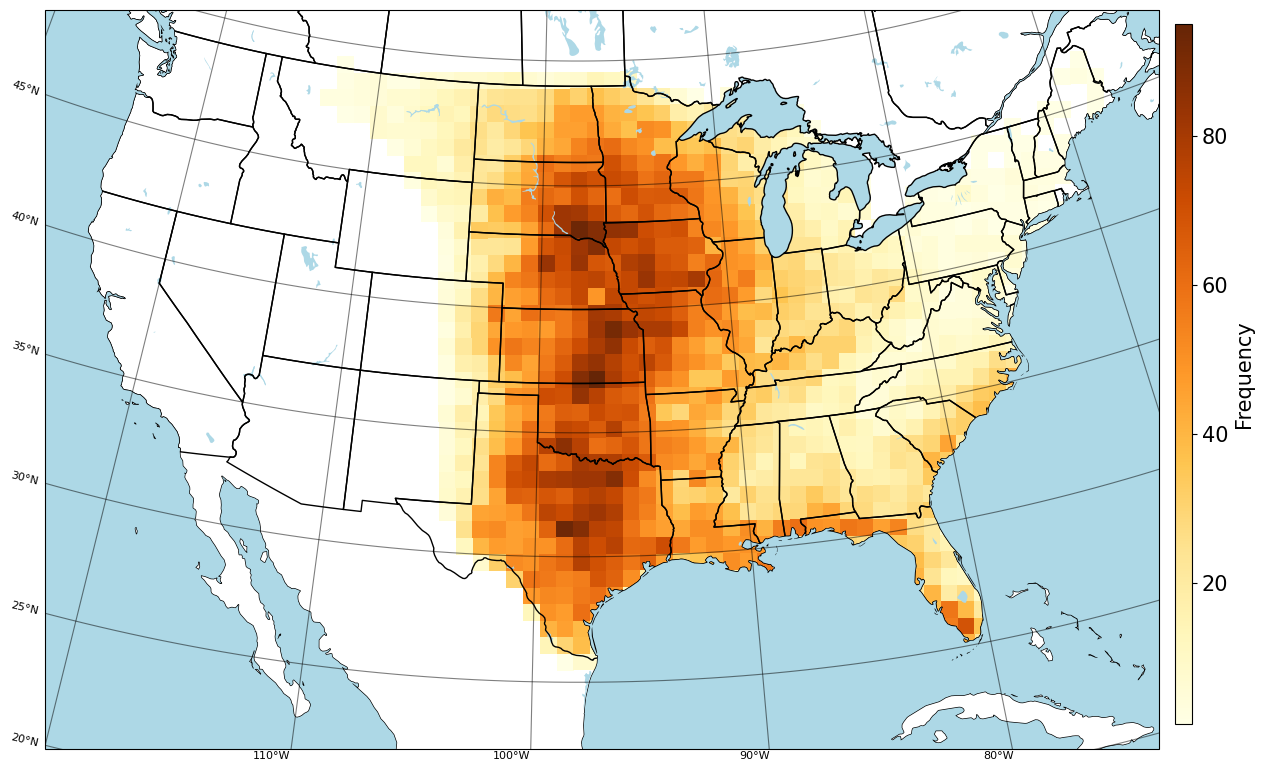

In [10]:
fig = plt.figure(figsize=(16.5,10))
#plt.suptitle('Occurrence of Surrogoate Severe', size=35).set_weight('bold')
ax = plt.subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])
plt.subplots_adjust(right=0.8)

data = np.sum(ds.UVV_DAYS.values, axis=0).astype(np.float32)
data[data==0] = np.nan


c = ax.pcolormesh(ds.CLONG.values[0,:,:], ds.CLAT.values[0,:,:], data, transform=cartopy.crs.PlateCarree(), cmap='YlOrBr')

ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.LAND, facecolor='white')
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder=2)
ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')

ax.set_extent([-120, -74, 20, 50])

#add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, dms=True, x_inline=False, y_inline=False, zorder=10,
              color='k', alpha=0.5)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 8, 'color': 'k', 'rotation': 0.01}
gl.ylabel_style = {'size': 8, 'color': 'k'}


cbar = plt.colorbar(c, pad=0.01, ax=ax, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(label='Frequency', size=15)
plt.savefig('/home/jcorner1/Future_Modes/Plots/sur_sev_occurrence_coar.png', format='png', dpi=500, bbox_inches='tight')

### Reports

In [12]:
results = np.zeros(shape=(899, 1399))
#iterate through the dataframes
for did, day in df.resample('24h', origin='1990-10-01 12:00:00', on='Time'):
    results[day.y.values.astype(int), day.x.values.astype(int)] = results[day.y.values.astype(int), day.x.values.astype(int)] + 1

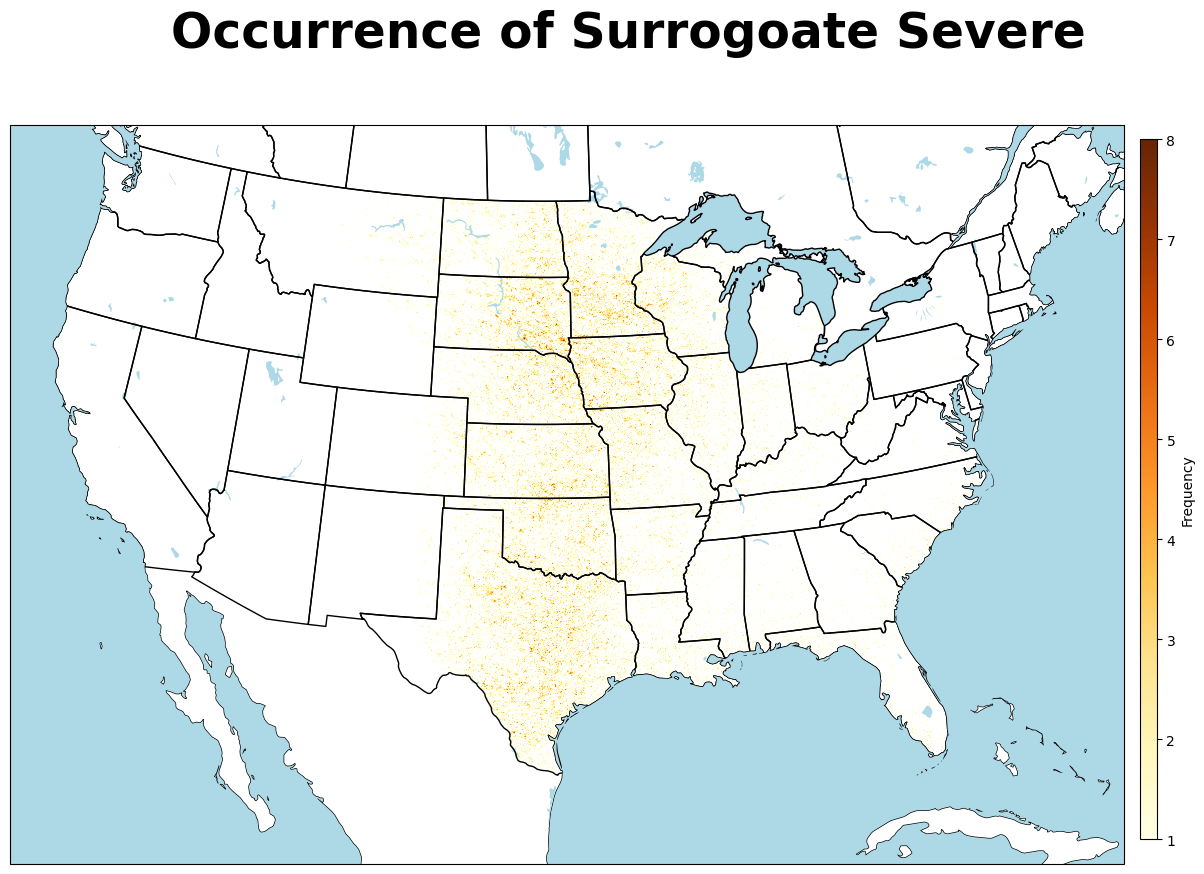

In [15]:
fig = plt.figure(figsize=(16.5,10))
plt.suptitle('Occurrence of Surrogoate Severe', size=35).set_weight('bold')
ax = plt.subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))
cbar_ax = fig.add_axes([0.81, 0.15, 0.01, 0.7])
plt.subplots_adjust(right=0.8)

results[results==0] = np.nan


c = ax.pcolormesh(geog.CLONG.values[0,:,:], geog.CLAT.values[0,:,:], results, transform=cartopy.crs.PlateCarree(), cmap='YlOrBr')

ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.LAND, facecolor='white')
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue', zorder=2)
ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')

ax.set_extent([-120, -74, 20, 50])

cbar = plt.colorbar(c, pad=0.01, ax=ax, cax=cbar_ax)
cbar.ax.tick_params(labelsize=15)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='Frequency', size=10)
plt.savefig('/home/jcorner1/Future_Modes/Plots/sur_sev_occurrence.png', format='png', dpi=500, bbox_inches='tight')